In [1]:
%reload_kedro

2020-02-10 21:13:22,006 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-02-10 21:13:22,007 - root - INFO - Defined global variable `context` and `catalog`


In this notebook, we introduce topic modeling methods through the [UN General Debates Dataset from Kaggle](https://www.kaggle.com/unitednations/un-general-debates), using [gensim](https://radimrehurek.com/gensim/).

In [2]:
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel

%matplotlib inline

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Data

In [4]:
docs=catalog.load("UN_dataset")
print(len(docs))
docs.head()

2020-02-10 21:13:26,529 - kedro.io.data_catalog - INFO - Loading data from `UN_dataset` (CSVLocalDataSet)...
7507


,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [5]:
docs = docs.reset_index().drop(columns=['session', 'country'])

# Preprocessing

# Training

In [6]:
from gensim.corpora import Dictionary, MmCorpus

corpus = catalog.load("UN_corpus")
dictionary = catalog.load("UN_dictionary")

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

2020-02-10 21:13:34,413 - kedro.io.data_catalog - INFO - Loading data from `UN_corpus` (MmCorpusDataSet)...
2020-02-10 21:13:34,497 - kedro.io.data_catalog - INFO - Loading data from `UN_dictionary` (DictionaryDataSet)...
Number of unique tokens: 12459
Number of documents: 7507


In [19]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, \
                       id2word=id2word, \
                       chunksize=chunksize, \
                       alpha='auto', \
                       eta='auto', \
                       iterations=iterations, \
                       num_topics=num_topics, \
                       passes=passes, \
                       eval_every=eval_every)

CPU times: user 32min 49s, sys: 1min 10s, total: 34min
Wall time: 8min 51s


# Visualisation

In [17]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

In [18]:
%time vis_data = gensimvis.prepare(model, corpus, dictionary) # MDS available : pcoa, tsne, mmds
pyLDAvis.display(vis_data)

2020-02-05 01:37:01,711 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


/home/alexandre/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 2min 7s, sys: 4.79 s, total: 2min 12s
Wall time: 4min 36s


In [ ]:
pyLDAvis.save_html(vis_data, "data/07_model_output/UNGD_vis_lda.html")

# Optimal number of topics

In [21]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    passes = 20
    iterations = 400
    eval_every = None
    
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, eval_every=eval_every, alpha='auto', \
                       eta='auto', iterations=iterations)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
    
    return lm_list, c_v

def c_v_plot(c_v, limit):
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

In [ ]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=docs['text'], limit=20)

In [27]:
c_v

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [39]:
pickle.dump( lmlist, open( "data/06_models/lmlist.p", "wb" ) )

In [17]:
lmlist = pickle.load( open( "data/06_models/lmlist.p", "rb" ) )

In [18]:
perp = []
for lda_model in lmlist:
    perp.append(lda_model.log_perplexity(corpus))

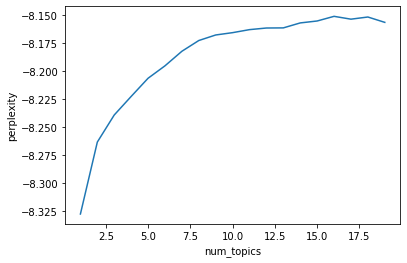

In [19]:
limit = 20
x = range(1, limit)
plt.plot(x, perp)
plt.xlabel("num_topics")
plt.ylabel("perplexity")
plt.show()

In [20]:
pd.set_option('display.max_colwidth', 10000)

def most_relevant_docs(topic_number, lda_model, n):
    my_ids = np.linspace(start=1, stop=len(docs), num=len(docs))
    tops = sorted(zip(my_ids, lda_model[corpus]), reverse=True, key=lambda x: abs(dict(x[1]).get(topic_number, 0.0)))[:n]
    return([int(x[0]) for x in tops])

def topic_per(topic_number, lda_model, thres):
    cnt = 0
    for x in range(len(corpus)):
        for topic, pr in lda_model[corpus[x]]:
            if topic == topic_number and pr > thres:
                cnt+=1
    return("{0:.0%}".format(cnt / len(lda_model[corpus])))

def topic_display(lda_model, num_docs, thres):
    topics = lda_model.show_topics(formatted=False, num_topics=20)
    df = pd.DataFrame([[idx, [x for x,y in words], "{0:.0%}".format(lda_model.alpha[idx]), most_relevant_docs(idx, lda_model, num_docs), topic_per(idx, lda_model, thres)] for idx,words in topics]).sort_index().drop(columns=[0])
    df.columns = ['Most relevant words', 'Prior', 'Most relevant docs', 'docs with probability > thres']
    return(df)

In [21]:
%time topic_display(lmlist[8], 2, 0.2)

CPU times: user 35min 3s, sys: 1min 18s, total: 36min 21s
Wall time: 9min 8s


,Most relevant words,Prior,Most relevant docs,docs with probability > thres
0,"[soviet, co, europe, union, disarmament, viet, struggle, korea, nam, china]",6%,"[6005, 5946]",8%
1,"[democracy, central, solidarity, summit, debt, strengthening, continent, strengthen, lasting, priority]",16%,"[6140, 2663]",28%
2,"[co, namibia, regime, apartheid, struggle, southern, mankind, disarmament, aligned, racist]",10%,"[5827, 5934]",28%
3,"[america, american, latin, say, know, democracy, said, century, word, let]",15%,"[7119, 5506]",24%
4,"[arab, israel, iraq, israeli, lebanon, palestine, aggression, iran, islamic, terrorism]",8%,"[7189, 3829]",11%
5,"[european, terrorism, europe, union, humanitarian, japan, peacekeeping, democracy, bosnia, terrorist]",8%,"[7358, 7117]",17%
6,"[somalia, afghanistan, sudan, refugee, pakistan, burundi, liberia, congo, rwanda, ethiopia]",7%,"[4138, 6052]",8%
7,"[disarmament, treaty, keeping, growth, let, approach, report, look, convention, membership]",21%,"[755, 6730]",34%
8,"[island, small, climate, sustainable, millennium, per, address, pacific, terrorism, caribbean]",12%,"[4388, 232]",25%


# Pseudo dynamic LDA

In this section, we will train a LDA on all the dataset and then use it year by year to see topic representativeness over time.

In [22]:
time_slice = pd.DataFrame(docs.year.value_counts()).reset_index().sort_values(by="index").reset_index().drop(columns=["level_0", "index"]).values.reshape((1,46))[0]
time_slice

array([ 70, 116, 125, 120, 129, 126, 134, 140, 141, 144, 149, 145, 147,
       149, 150, 137, 149, 152, 154, 153, 156, 162, 167, 175, 178, 172,
       181, 176, 181, 181, 178, 189, 188, 189, 192, 185, 193, 191, 192,
       193, 189, 194, 195, 193, 194, 193])

In [23]:
lda_model = lmlist[4]

time_per = []
t_prev = 0
for t_max in time_slice:
    curr_per = [0] * lda_model.num_topics
    for x in range(t_prev, t_prev + t_max - 1):
        for topic, pr in lda_model[corpus[x]]:
            if pr > 0.2:
                curr_per[topic] += 1
    curr_per = curr_per / t_max
    t_prev += t_max
    time_per.append(curr_per)

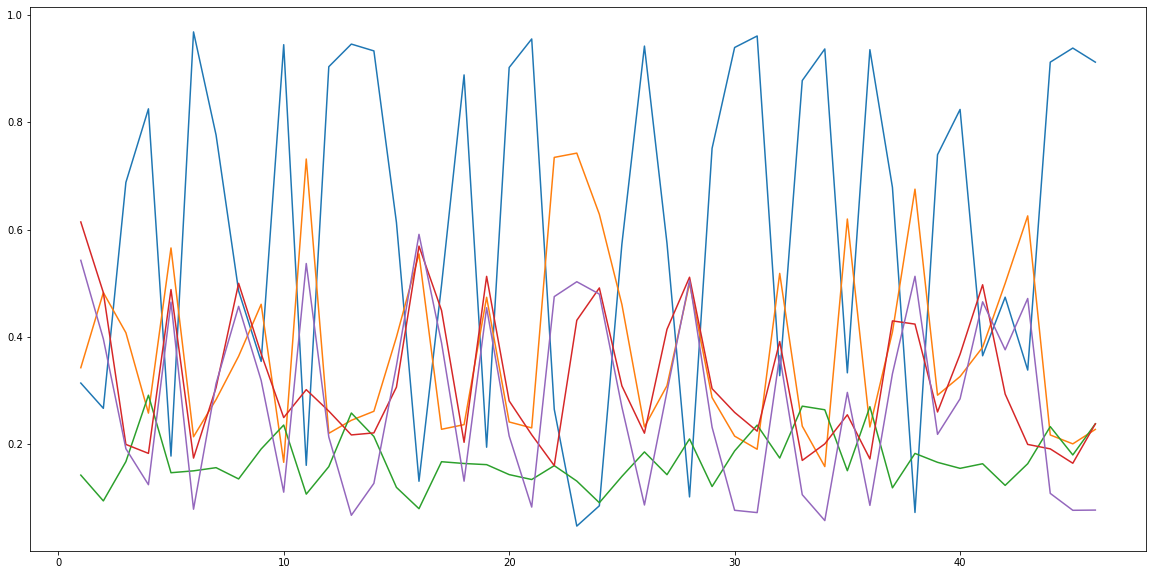

In [24]:
time = np.linspace(1, len(time_slice), len(time_slice))
plt.figure(figsize=(20,10))
plt.plot(time, time_per)
#plt.plot(time, [x[3] for x in time_per])
plt.show()